In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import sys
ROOT_DIR = r'C:\Users\chaoL\Documents\Project\Exploring the FIS in the Rashomon set'
sys.path.append(r"{}\src".format(ROOT_DIR))
from FIS_explainer import fis_explainer
from feature_importance_helper import *
from general_utilities import *
from visulizer import *
# from feature_interaction_helper import *
from feature_interaction_score_utilities import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load dataset and define Logistic regressor from VIC results
## Data source is from [VIC](https://zenodo.org/record/4065582)

In [2]:
DATA_DIR = ROOT_DIR + '\data'
RECIDIVISM_DATA_DIR = DATA_DIR + '\Recidivism prediction\compas.csv'

In [3]:
data = pd.read_csv(RECIDIVISM_DATA_DIR, usecols=['Age=18-20', 'Race=African-American', 'Prior-Crimes=0','Gender=Male', 'Juvenile-Crimes=0', 'Current-Charge-Degree=Misdemeanor'])
X = data.rename({'Age=18-20':"age", 'Race=African-American':"race", 'Prior-Crimes=0':"prior", 'Gender=Male':"gender", 'Juvenile-Crimes=0':"juvenilecrime", 'Current-Charge-Degree=Misdemeanor':"currentcharge"}, axis='columns')
y = pd.read_csv(RECIDIVISM_DATA_DIR, usecols=['Recidivate-Within-Two-Years'])

vlist = ["age", "race", "prior", "gender", "juvenilecrime", "currentcharge"]
X, y = pd_to_numpy(X, y)
X_added_constant = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X_added_constant, y, random_state = 2020, test_size=0.3)

In [4]:
model_optimal = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.640067
         Iterations 6


In [5]:
model_optimal.params

array([ 0.5135943 ,  1.47907345,  0.37454913,  0.34567361, -0.88014319,
       -0.88542201, -0.16979384])

In [6]:
# Model from VIC using R studio, can be found in [VIC](https://zenodo.org/record/4065582)
model_vic = sm.Logit(y_train, X_train).fit()
coefs = np.array([0.5435123, 1.4684052, 0.3521730, -0.8664713, 0.3207619, -0.8815762, -0.2340473])
for idx, weight in enumerate(coefs):
    model_vic.params[idx] = weight
loss_ref, _ = calculate_boundary(y_train, model_vic.predict(X_train), epsilon_rate=0.05, regression=False)
print('Loss of new model is ', loss_ref)

Optimization terminated successfully.
         Current function value: 0.640067
         Iterations 6
Loss of new model is  0.7276876051878167


## Build explainer for VIC comparison

In [7]:
'''
Feature importance range, comparing with VIC. Noted that they used ratio, so we followed that for comparison using MR. Same model, same evaluation protocol, different exploring method
'''
fis_reg_vic = fis_explainer(model_vic, X_train, y_train, epsilon_rate=0.05, loss_fn='classification')

In [16]:
m_all_vic, points_all_max_vic, points_all_min_vic, fis_all_vic = fis_reg_vic.explore_m_in_R(fis_reg_vic.epsilon, fis_reg_vic.loss, range(len(X_test[-1])), model_vic, X_train, y_train, delta=0.1, regression=fis_reg_vic.regression)

Searching started...
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 0.005535126807670765
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 0.000523877318494792
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 5.209059907040903e-05
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 5.206087826392647e-06
Feature 0 at boundary 0.1 * epsilon with m 1 achieves loss 0.005535126807670765
Feature 0 at boundary 0.1 * epsilon with m 1.01 achieves loss 0.000523877318494792
Feature 0 at boundary 0.1 * epsilon with m 1.02 achieves loss 0.0010543543546210898
Feature 0 at boundary 0.1 * epsilon with m 1.03 achieves loss 0.0015914259518994278
Feature 0 at boundary 0.1 * epsilon with m 1.04 achieves loss 0.0021350868826760516
Feature 0 at boundary 0.1 * epsilon with m 1.05 achieves loss 0.002685331848331751
Feature 0 at boundary 0.1 * epsilon with m 1.06 achieves loss 0.003242155479496356
Feature 0 at boundary 0.1 * epsilon with m 1.06 achieves loss 0.003805552336

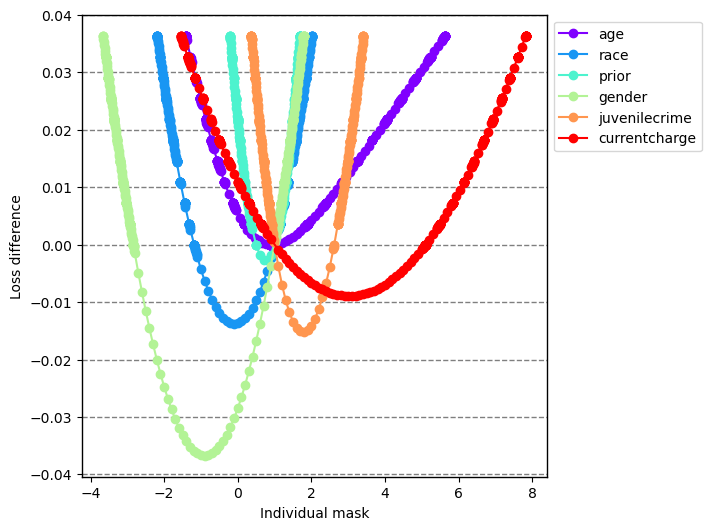

In [9]:
# Visualizing training process
m_training_process_vis(points_all_max_vic[1:], points_all_min_vic[1:], vlist, save=False, suffix='vic_raw')

In [17]:
m_all_sub_set = fis_reg_vic._get_all_m_with_t_in_range(points_all_max_vic, points_all_min_vic, fis_reg_vic.epsilon)

In [11]:
MR_all_ratio = np.ones((5, 11, 7, 2))
for idx, sub_boundary_rate in enumerate(np.arange(0.2, 1.2, 0.2)):
    for i in range(11):
        for j in range(7):
            for k in range(2):
                X0 = X_test.copy()
                X0[:, j] = X0[:, j] * m_all_sub_set[idx, i, j, k]
                MR_all_ratio[idx, i, j, k] = MR(j, X0, y_test, fis_reg_vic.model)

In [12]:
results_vic_comparison = np.zeros((7,4))
for i in range(7):
    results_vic_comparison[i, 0] = np.max(MR_all_ratio[:, :, i, :])
    results_vic_comparison[i, 1] = np.min(MR_all_ratio[:, :, i, :])
    results_vic_comparison[i, 2] = np.max(MR_all_ratio[:, :, i, :]) - np.min(MR_all_ratio[:, :, i, :])
    results_vic_comparison[i, 3] = np.mean(MR_all_ratio[:, :, i, :])
results_vic_comparison

array([[1.16909278, 1.        , 0.16909278, 1.14368728],
       [1.34131436, 1.2683287 , 0.07298566, 1.31958053],
       [1.05567532, 0.98779672, 0.06787859, 1.03760854],
       [1.0370578 , 0.98333221, 0.05372558, 1.02160008],
       [1.5107271 , 1.08177898, 0.42894813, 1.46473898],
       [1.28060154, 1.22051075, 0.06009078, 1.2608734 ],
       [1.03314641, 0.95638352, 0.07676289, 1.01431704]])

In [20]:
np.savetxt("../results/crime/crime_vic/result_vic_comparison.csv", results_vic_comparison, delimiter=",")

### Save and load outputs

## Optimal model explainer

In [58]:
fis_reg_optimal = fis_explainer(model_optimal, X_train, y_train, epsilon_rate=0.1, loss_fn='classification', return_ref_main_effects=True,return_ref_pairwise_effects=True)

In [20]:
m_all_optimal, points_all_max_optimal, points_all_min_optimal, fis_all_optimal = fis_reg_optimal.explore_m_in_R(fis_reg_optimal.epsilon, fis_reg_optimal.loss, fis_reg_optimal.v_list, fis_reg_optimal.model, X_train, y_train, delta=0.1, regression=False)

Searching started...
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 0.000296654309054456
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 2.9655230413538902e-06
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 2.965399104049027e-08
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 2.9653868249823745e-10
Feature 0 at boundary 0.1 * epsilon with m 1.1 achieves loss 0.000296654309054456
Feature 0 at boundary 0.1 * epsilon with m 1.2000000000000002 achieves loss 0.001186883304653441
Feature 0 at boundary 0.1 * epsilon with m 1.3000000000000003 achieves loss 0.002670642137300616
Feature 0 at boundary 0.1 * epsilon with m 1.4000000000000004 achieves loss 0.00474729445202593
Feature 0 at boundary 0.1 * epsilon with m 1.4000000000000004 achieves loss 0.007415614722421249
Feature 0 at boundary 0.1 * epsilon with m 1.4100000000000004 achieves loss 0.004987526725552582
Feature 0 at boundary 0.1 * epsilon with m 1.4200000000000004 achieves loss 0.0052336746

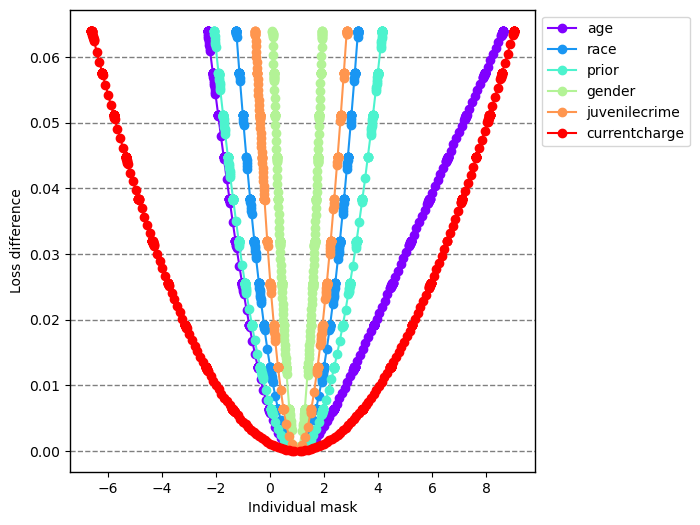

In [21]:
m_training_process_vis(points_all_max_optimal[1:], points_all_min_optimal[1:], vlist, save=False, suffix='optimal')

In [72]:
fis_reg_optimal.explain()

Searching started...
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 0.000296654309054456
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 2.9655230413538902e-06
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 2.965399104049027e-08
Feature 0 at boundary 0.0 * epsilon with m 1 achieves loss 2.9653868249823745e-10
Feature 0 at boundary 0.1 * epsilon with m 1.1 achieves loss 0.000296654309054456
Feature 0 at boundary 0.1 * epsilon with m 1.2000000000000002 achieves loss 0.001186883304653441
Feature 0 at boundary 0.1 * epsilon with m 1.3000000000000003 achieves loss 0.002670642137300616
Feature 0 at boundary 0.1 * epsilon with m 1.4000000000000004 achieves loss 0.00474729445202593
Feature 0 at boundary 0.1 * epsilon with m 1.4000000000000004 achieves loss 0.007415614722421249
Feature 0 at boundary 0.1 * epsilon with m 1.4100000000000004 achieves loss 0.004987526725552582
Feature 0 at boundary 0.1 * epsilon with m 1.4200000000000004 achieves loss 0.0052336746

# Swarmplot
### Comparing with VIC, they only show pairwise information, missing higher order
### With prior, they compensate using others (information loss can be compensated by others) e.g. race is the minimum, but our plot shows that race and prior interaction is higher than others, as the interaction strength is strong, so the loss of information is not easy to compensate.

In [23]:
m_all_sub_set_optimal = fis_reg_optimal._get_all_m_with_t_in_range(points_all_max_optimal, points_all_min_optimal, fis_reg_optimal.epsilon)
all_main_effects_ratio, all_main_effects_diff  = fis_reg_optimal._get_all_main_effects(m_all_sub_set_optimal, X_test, y_test, fis_reg_optimal.model)

In [25]:
joint_effect_all_pair_set, loss_emp_all_pair_set = fis_reg_optimal._get_all_joint_effects(m_all_sub_set_optimal)

In [29]:
fis_in_r = fis_reg_optimal._get_fis_in_r(fis_reg_optimal.all_pairs, np.array(joint_effect_all_pair_set), all_main_effects_diff)
loss_in_r = fis_reg_optimal._get_loss_in_r(fis_reg_optimal.all_pairs, np.array(loss_emp_all_pair_set))

In [44]:
fis_ref = fis_reg_optimal._get_ref_fis()
fis_ref

[((0, 1), 0.0005995689256340642),
 ((0, 2), 0.00013193311715820055),
 ((0, 3), 6.34961154284408e-05),
 ((0, 4), 0.00047937232150219167),
 ((0, 5), 0.0006910748250886778),
 ((0, 6), 9.998598592042551e-05),
 ((1, 2), 0.0003818318908042073),
 ((1, 3), 8.034685640057049e-05),
 ((1, 4), 0.0011323271665609758),
 ((1, 5), 0.0023679304561142756),
 ((1, 6), 0.000510469735892527),
 ((2, 3), 1.6609764926456272e-05),
 ((2, 4), 0.0006910645973621232),
 ((2, 5), 8.164292525325578e-05),
 ((2, 6), 8.073460078683592e-05),
 ((3, 4), 0.0010590827254887136),
 ((3, 5), 0.0027769090613680714),
 ((3, 6), 0.00038288501299044153),
 ((4, 5), 0.003902914057278384),
 ((4, 6), 0.0006722050868561702),
 ((5, 6), 0.0005499015736631918)]

In [50]:
vlist_intercept = ["intercept", "age", "race", "prior", "gender", "juvenilecrime", "currentcharge"]

In [51]:
fis_ref_l = [i[-1] for i in fis_ref]

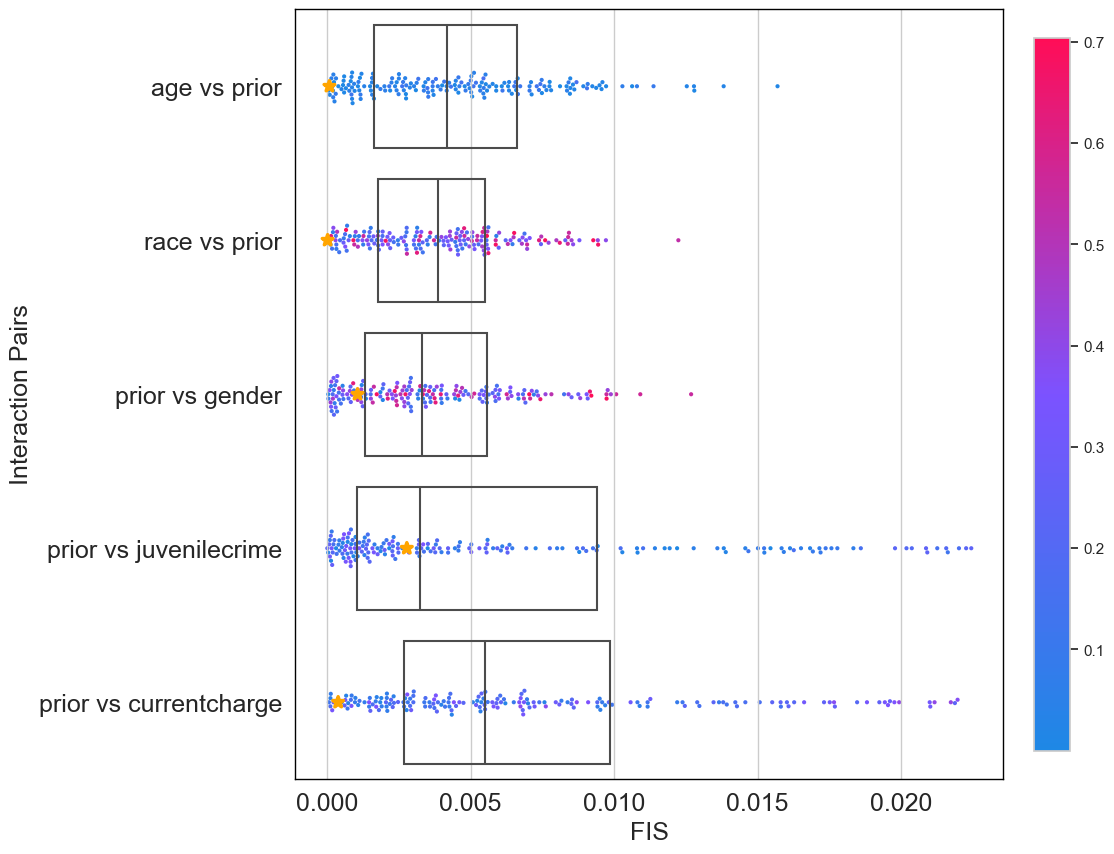

In [52]:
interest_pairs = [(1,3), (2,3) , (3,4), (3,5), (3,6)]
swarm_plot(fis_in_r, loss_in_r, fis_ref_l, fis_reg_optimal.all_pairs, interest_pairs, vname=vlist_intercept, threshold=None, loss=fis_reg_optimal.loss, epsilon=fis_reg_optimal.epsilon, boxplot=True, save=False, suffix='prior')

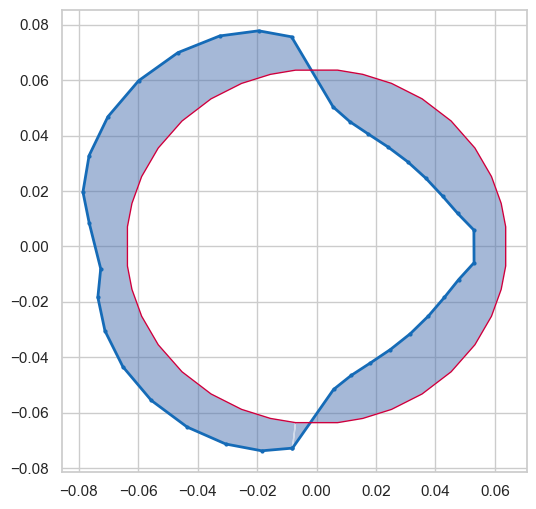

In [53]:
pairwise_vis_single(loss_emp_all_pair_set[-1], fis_reg_optimal.loss, fis_reg_optimal.epsilon, 16)

In [10]:
with open('../results/crime/crime_optimal/crime_m_all_set.npy', 'rb') as f:
    m_all_sub_set_optimal = np.load(f)

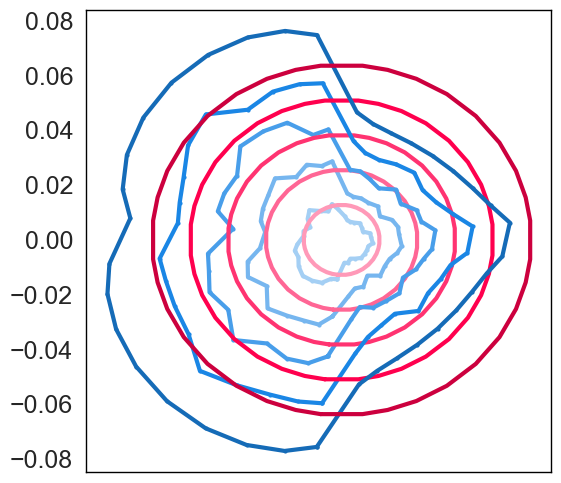

In [29]:
pairwise_vis_multi(fis_reg_optimal.loss, fis_reg_optimal.epsilon, all_pairs=fis_reg_optimal.all_pairs,pair_idx=16, model=fis_reg_optimal.model, m_all_sub_set=m_all_sub_set_optimal, X_test=X_test, y_test=y_test, regression=fis_reg_optimal.regression, loss_emp_all_pair_set=np.array(loss_emp_all_pair_set), save=True,
                   path='../results/crime/crime_optimal/juvenilecrime_prior_2d.png')

In [6]:
with open('../results/crime/crime_optimal/crime_m_all.npy', 'rb') as f:
    m_all = np.load(f)

In [9]:
joint_effect_all_pair_three, loss_emp_three = Interaction_effect_all_pairs(X_test, y_test, fis_reg_optimal.v_list, 3, fis_reg_optimal.model, m_all, regression=fis_reg_optimal.regression)

(0, 1, 2)
(0, 1, 3)


KeyboardInterrupt: 

In [86]:
with open('../results/crime/crime_optimal/joint_effect_all_pair_three.npy', 'wb') as f:
    np.save(f, joint_effect_all_pair_three)
with open('../results/crime/crime_optimal/loss_emp_three.npy', 'wb') as f:
    np.save(f, loss_emp_three)

In [30]:
with open('../results/crime/crime_optimal/joint_effect_all_pair_three.npy', 'rb') as f:
    joint_effect_all_pair_three = np.load(f)
with open('../results/crime/crime_optimal/loss_emp_three.npy', 'rb') as f:
    loss_emp_three = np.load(f)

In [31]:
find_all_n_way_feature_pairs(vlist, 3)

[('age', 'race', 'prior'),
 ('age', 'race', 'gender'),
 ('age', 'race', 'juvenilecrime'),
 ('age', 'race', 'currentcharge'),
 ('age', 'prior', 'gender'),
 ('age', 'prior', 'juvenilecrime'),
 ('age', 'prior', 'currentcharge'),
 ('age', 'gender', 'juvenilecrime'),
 ('age', 'gender', 'currentcharge'),
 ('age', 'juvenilecrime', 'currentcharge'),
 ('race', 'prior', 'gender'),
 ('race', 'prior', 'juvenilecrime'),
 ('race', 'prior', 'currentcharge'),
 ('race', 'gender', 'juvenilecrime'),
 ('race', 'gender', 'currentcharge'),
 ('race', 'juvenilecrime', 'currentcharge'),
 ('prior', 'gender', 'juvenilecrime'),
 ('prior', 'gender', 'currentcharge'),
 ('prior', 'juvenilecrime', 'currentcharge'),
 ('gender', 'juvenilecrime', 'currentcharge')]

In [70]:
ball_exp, ball_emp = high_order_vis_loss(loss_emp_three[-2], fis_reg_optimal.epsilon, 3, fis_reg_optimal.loss)

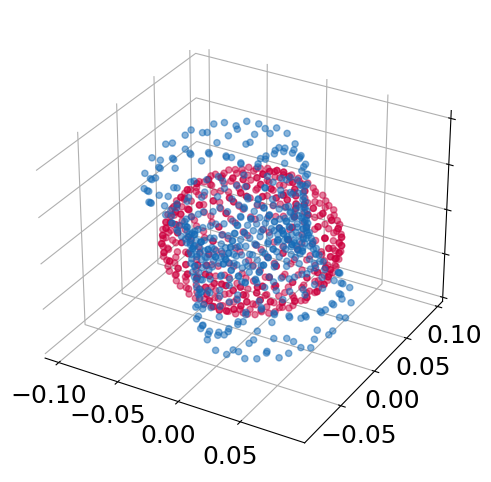

In [76]:
fis_vis_3D(ball_exp, ball_emp, save=True, path='../results/crime/crime_optimal/currentcharge_juvenilecrime_prior_3d.png')